## Importing

In [1]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import get_point_biserial, get_binned_prediction, ColorBGR
import scipy.stats as stats
import traceback
from typing import List

pn.extension()

## Initializing Variables and Widgets

In [2]:
# Note: to add another global variable, need to init, add to global term, and define an update based on run
# TODO: download new inputdf, diagnostic, gt_freqs and change below variables to visualize.

title = '# Visualize Input Features'
tag = 'may_30_grid_alfa1E+04_lmda1E+08'
# tag = 'may_10_no_skel2D_selection'
default_run = '2.2.10'
epoch = '1'
# epoch = ''

# Load sample input dfs:
runs = glob('output/skel/*_kinect_skel_features.csv')
runs = [os.path.basename(x).split('_')[0] for x in runs]
run_select = pn.widgets.Select(name='Select Run', options=runs, value=f'{default_run}')
skel_checkbox = pn.widgets.Checkbox(name='Display Skeleton?')
obj_checkbox = pn.widgets.Checkbox(name='Display Nearest Objects?')
z_checkbox = pn.widgets.Checkbox(name='Z-score time courses?')
# Options and values for these widgets are just placeholders, will be updated based on run by listen_to_run 
frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list([0, 1, 2, 3]), value=0)
text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')
second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list([0, 1, 2, 3]), value=0)
tc_feature_select = pn.widgets.MultiSelect(name='Select Time Course Features', value=['features[3]', 'features[4]'], options=['features[3]','features[4]'], size=8)
pair_feature_select = pn.widgets.MultiSelect(name='Select 2 or 3 Features for Comparison', value=['features[3]' ,'features[4]'],options=['features[3],features[4]'], size=8)
# holder to update later.
epochs=glob(f'output/run_sem/{tag}/{default_run}_kinect_trim{tag}_diagnostic_*.pkl')
epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
epochs.sort(key=int)
epoch_select = pn.widgets.Select(name='Select epoch', options=epochs, value=f'{epochs[0]}')


second_interval = 1 # interval to group boundaries
frame_per_second = 3 # sampling rate to input to SEM
fps = 25.0 # kinect videos
frame_interval = frame_per_second * second_interval

# declare global variables that will be used for each individual runs (to save loading time)
skel_df, appear_df, flow_df, objdf, objhand_post, anchored_frames, appear_df_post, flow_df_post, skel_df_post, gt_freqs, \
sem_readouts, inputdf, first_frame, offset, pca_input_df, pred_skel_df, skel_df_unscaled,categories, pred_objhand, word2vec, objhand_df = [None] * 21

# glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
glove_vectors = pkl.load(open('gen_sim_glove_50.pkl', 'rb'))

## Linking Widgets and Updating Global Variables

In [3]:
def second_to_frame(frame_slider, second):
    frameid = int(float(second.new) * 25)
    while frameid not in anchored_frames:
        frameid += 1
    frame_slider.value = frameid
second_slider.link(frame_slider, callbacks={'value': second_to_frame})
def text_to_secondsl(second_slider, text):
    second = int(text.new)
    second_slider.value = second
text_input.link(second_slider, callbacks={'value': text_to_secondsl})

def run_to_epoch(epoch_select, run):
    epochs = glob(f'output/run_sem/{tag}/{run.new}_kinect_trim{tag}_diagnostic_*.pkl')
    epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
    epochs.sort(key=int)
    # if the new run doesn't have the value of previous value, epoch_select.value will be
    # assigned default value epochs[0]. In that case, listen_to_run will be triggered twice.
    # if the new run has the value of the previous value, epoch_select.value will be the
    # previous value, not triggering listen_to_run. However, the UI epoch_select will appears epochs[0].
    epoch_select.options = epochs
    print('Done updating epoch due to a change in run!')
run_select.link(epoch_select, callbacks={'value': run_to_epoch})


@pn.depends(run_select, epoch_select)
def listen_to_run(run_select, epoch_select):
    print(f'Run or Epoch changed: run={run_select}, epoch={epoch_select}, update...')
    global skel_df, appear_df, flow_df, objdf, objhand_post, anchored_frames, appear_df_post, flow_df_post, skel_df_post, \
        gt_freqs, sem_readouts, inputdf, first_frame, offset, pca_input_df, pred_skel_df, skel_df_unscaled,categories, pred_objhand, word2vec, objhand_df
    # These are dataframes before processing (standardizing, interpolating, concatenating, dropna, resample)
    skel_df=pd.read_csv(f'output/skel/{run_select}_kinect_skel_features.csv')
    objhand_df = pd.read_csv(os.path.join(f'output/objhand/{run_select}_kinect_objhand.csv'))
    appear_df = pd.read_csv(f'output/appear/{run_select}_kinect_appear.csv')
    flow_df=pd.read_csv(f'output/vid/{run_select}_kinect_video_features.csv')
    # Seem like loading csv files is one bottleneck
    print('Done loading feature csv files')
    # Caching frames to speed up interactive time
#     anchored_frames = pkl.load(open(f'output/run_sem/{tag}/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb'))
    anchored_frames = joblib.load(f'output/run_sem/frames/{run_select}_kinect_trimjan_27_pca_frames.joblib')
    # Seem like loading cached frames is one bottleneck
    print('Done loading cached frames')
    # This data is for plotting diagnostic results
    gt_freqs = pkl.load(open(f'output/run_sem/{tag}/{run_select}_kinect_trim{tag}_gtfreqs.pkl', 'rb'))
    sem_readouts = pkl.load(open(f'output/run_sem/{tag}/{run_select}_kinect_trim{tag}_diagnostic_{epoch_select}.pkl', 'rb'))
    inputdf = pkl.load(open(f'output/run_sem/{tag}/{run_select}_kinect_trim{tag}_inputdf_{epoch_select}.pkl', 'rb'))
    print('Done loading inputdf and diagnostic pickles')
    # offset to align prediction boundaries with exact video timepoint
    first_frame = inputdf.skel_post.index[0]
    offset = first_frame / fps / second_interval
    
    appear_df_post = inputdf.appear_post
    flow_df_post = inputdf.optical_post
    skel_df_post = inputdf.skel_post
    objhand_post=inputdf.objhand_post
    
    # Prepare dataframes to plot input skeleton and predicted skeleton
    # skel_df_unscaled for sanity check, comparing to skel_df.
    pca_input_df = inputdf.x_train_inverted
    pred_skel_df = inputdf.x_inferred_inverted
#     skel_df_unscaled = skel_df_post.copy().loc[:, skel_df_post.columns]
    pred_skel_df = pred_skel_df.loc[:, skel_df_post.columns]
    pca_input_df = pca_input_df.loc[:, skel_df_post.columns]

#     skel_df_unscaled = skel_df_unscaled * skel_df.std() + skel_df.mean()
    pred_skel_df = pred_skel_df * skel_df.std() + skel_df.mean()
    pca_input_df = pca_input_df * skel_df.std() + skel_df.mean()

#     skel_df_unscaled['frame'] = skel_df_unscaled.index
    pred_skel_df['frame'] = pred_skel_df.index
    pca_input_df['frame'] = pca_input_df.index
    for i in range(25):
        new_column = f'J{i}_Tracked'
#         skel_df_unscaled[new_column] = 'Inferred'
        pred_skel_df[new_column] = 'Predicted'
        pca_input_df[new_column] = 'Inferred'
    print('Done preprocessing skel dataframes')
    # Add two new distances columns to objhand_post
    # TODO: refactor so that it doesn't change the original dataframe
    i=1
    dists=[0]
    euc_dists = [0]
    while i < len(objhand_post):
        dists.append(cosine(objhand_post.iloc[i],objhand_post.iloc[i-1]))
        euc_dists.append(np.linalg.norm(objhand_post.iloc[i] - objhand_post.iloc[i-1]))
        i+=1
    objhand_post['cosine']=dists
    objhand_post['euclid'] = euc_dists
    print('Done adding euclid and cosine distance columns')
    # Prepare a dictionary of word2vec for this particular run
    # categories are not stored in later version of inputdf for speed => comment
    # categories = set()
    # for c in inputdf.categories.columns:
    #     categories.update(inputdf.categories.loc[:, c].dropna())
    # if None in categories:
    #     categories.remove(None)

    pred_objhand = inputdf.x_inferred_inverted
    pred_objhand = pred_objhand.loc[:, objhand_post.drop(['euclid', 'cosine'], axis=1, errors='ignore').columns]
    # word2vec = dict()
    # for category in categories:
    #     r = np.zeros(shape=(1, pred_objhand.shape[1]))
    #     try:
    #         r += glove_vectors[category]
    #     except Exception as e:
    #         words = category.split(' ')
    #         for w in words:
    #             w = w.replace('(', '').replace(')', '')
    #             r += glove_vectors[w]
    #         r /= len(words)
    #     word2vec[category] = r

    # Update sliders
    # Tested, when changing epoch only update the panel once since
    # frame_slider derived from second_slider is the same
    frame_slider.options = list(anchored_frames.keys())
    frame_slider.value=list(anchored_frames.keys())[0]
    second_slider.options=list(np.arange(inputdf.skel_post.index[0] // fps, inputdf.skel_post.index[-1] // fps))
    second_slider.value=inputdf.skel_post.index[0] // fps

    features = skel_df_post.columns.tolist()
    tc_feature_select.options = features
    tc_feature_select.value = [features[3],features[4]]
    pair_feature_select.options=features
    pair_feature_select.value=[features[3],features[4]]

    print('Done Updating variables!')


In [6]:
# listen_to_run(run_select=run_select.value, epoch_select=epoch_select.value)


Run or Epoch changed: run=1.1.10, epoch=1, update...
Done loading feature csv files
Done loading cached frames
Done loading inputdf and diagnostic pickles
Done preprocessing skel dataframes
Done adding euclid and cosine distance columns
Done Updating variables!


In [5]:
# run_select.value = '1.1.10'
# listen_to_run(run_select=run_select.value, epoch_select=epoch_select.value)

Done updating epoch due to a change in run!
Run or Epoch changed: run=1.1.10, epoch=1, update...
Done loading feature csv files
Done loading cached frames
Done loading inputdf and diagnostic pickles
Done preprocessing skel dataframes
Done adding euclid and cosine distance columns
Done Updating variables!


## Appear Features

In [87]:
@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Appearances and Disappearances '+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'], index=pred_objhand.index)
    ax.vlines(df[df['switch'] == 'new_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot_post(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df_post.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances Post'+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'], index=pred_objhand.index)
    ax.vlines(df[df['switch'] == 'new_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

## Skeleton Features

In [77]:
@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in tc_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
            #df[feat]=df[feat].apply(zscore)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / fps
    for feat in tc_feature_select:
        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Feature Time Course '+run_select)
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def pair_plot(pair_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in pair_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
    pdf = df[df['frame'] == frame_slider]
        
    if len(pair_feature_select) == 2:
        fig,ax = plt.subplots()
        df.plot(kind='scatter', x=pair_feature_select[0], y=pair_feature_select[1],alpha=0.5,c=df['frame'],colormap='viridis',ax=ax)
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],marker='o',markersize=15,color='r',alpha=0.5)
    elif len(pair_feature_select) == 3:
        fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
        p=ax.scatter(df[pair_feature_select[0]],df[pair_feature_select[1]],df[pair_feature_select[2]],c=df['frame'],cmap='viridis')
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],pdf[pair_feature_select[2]],marker='o',markersize=15,color='r')
        ax.set_xlabel(pair_feature_select[0])
        ax.set_ylabel(pair_feature_select[1])
        ax.set_zlabel(pair_feature_select[2])

        fig.colorbar(p)
    else:
        fig,ax = plt.subplots()
    plt.title('Compare Features '+run_select)
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_reduced_features(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=2, whiten=True)
    x_train = pca.fit_transform(x_train)
    df = pd.DataFrame(x_train, index=skel_df_post.index, columns=['pc_1', 'pc_2'])
    fig, ax = plt.subplots()
    df.plot(kind='scatter', x=df.columns[0], y=df.columns[1],alpha=0.5,c=df.index,colormap='viridis',ax=ax)
    ax.plot(df.loc[frame_slider, 'pc_1'], df.loc[frame_slider, 'pc_2'], marker='o',markersize=15,color='r',alpha=0.5)
    ax.set_title('Principal Components for Skeletons')
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(cosine(x_train[i], x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Cosine Disntance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post_euclid(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Euclidean Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'], index=pred_objhand.index)
    ax.vlines(df[df['switch'] == 'new_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close()
    return fig

## Object-Hand Features

In [78]:


@pn.depends(frame_slider.param.value,run_select.param.value)
def objhand_plot(frame_slider,run_select): # start function
    x_train = objhand_post.drop(['cosine', 'euclid'], errors='ignore').to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=objhand_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Objhand PCA Euclid Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')

    
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'], index=pred_objhand.index)
    ax.vlines(df[df['switch'] == 'new_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig

## Video Features

In [79]:

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df.reset_index()
    if z_checkbox:
        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Pixel Correlation '+run_select)
    ax.get_legend().remove()
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot_post(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df_post.reset_index()
    if z_checkbox:
        df['optical_flow_avg'] = (df['optical_flow_avg'] - df['optical_flow_avg'].mean())/df['optical_flow_avg'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / fps
    df['optical_flow_avg'] = gaussian_filter1d(df['optical_flow_avg'].values, 5)
    df.plot(kind='line', x='second', y='optical_flow_avg', ax=ax, alpha=0.5)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Optical Flow Post '+run_select)
    ax.get_legend().remove()
    # Plotting diagnostic embeded in a function

    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'], index=pred_objhand.index)
    ax.vlines(df[df['switch'] == 'new_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / fps, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig


## Impose Skeletons and Objects on Frame

In [80]:
def remove_number(string):
    for i in range(100):
        string = string.replace(str(i), '')
    return string

def get_emb_category(category_distances, emb_dim=100):
    # Add 1 to avoid 3 objects with 0 distances (rare but might happen), then calculate inversed weights
    category_distances = category_distances + 1
    # Add 1 to avoid cases there is only one object
    category_weights = 1 - category_distances / (category_distances.sum() + 1)
    if category_weights.sum() == 0:
        print('Sum of probabilities is zero')
    average = np.zeros(shape=(1, emb_dim))
    for category, prob in category_weights.iteritems():
        r = np.zeros(shape=(1, emb_dim))
        try:
            r += glove_vectors[category]
        except Exception as e:
            words = category.split(' ')
            for w in words:
                w = w.replace('(', '').replace(')', '')
                r += glove_vectors[w]
            r /= len(words)
        average += r * prob
    return average / category_weights.sum()

# sr = objdf.iloc[96].dropna().filter(regex='_dist$').rename(lambda x: remove_number(x).replace('_dist', ''))
# arr = get_emb_category(sr, emb_dim=50)
# nearest_objects = glove_vectors.most_similar(arr)
# nearest_objects = [(nr[0], round(nr[1], 2)) for nr in nearest_objects]
# nearest_objects

In [81]:
def drawskel(frame_number, frame, skel_df, color=(255, 0, 0), thickness=2):
    # frame_number : video frame to select skeleton joints
    # frame : image frame to draw on
    # skel_df : df of skeleton joint coordinates
    # color : RGB tuple for color
    # thinkness : thickness to draw bone lines

    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920
    s = frame.shape[0] / 1080.0
    # ys = frame.shape[1]/1920.0
    # xs=1.0
    # ys=1.0
    r = skel_df[skel_df['frame'] == frame_number]

    def seg(bone, f):
        # draw segment between two joints
        ax = int(r['J' + str(bone[0]) + '_2D_X'].values[0] * s)
        ay = int(r['J' + str(bone[0]) + '_2D_Y'].values[0] * s)
        bx = int(r['J' + str(bone[1]) + '_2D_X'].values[0] * s)
        by = int(r['J' + str(bone[1]) + '_2D_Y'].values[0] * s)
        # print(ax,ay,bx,by)
        if all(x > 0 for x in (ax, ay, bx, by)):
            cv2.line(f, (ax, ay), (bx, by), color, thickness)
        return f

    for bone in [(3, 2), (2, 20), (20, 1), (1, 0),
                 (21, 7), (7, 6), (22, 6), (6, 5), (5, 4), (4, 20),
                 (20, 8), (8, 9), (9, 10), (24, 10), (10, 11), (11, 23),
                 (0, 12), (12, 13), (13, 14), (14, 15),
                 (0, 16), (16, 17), (17, 18), (18, 19)]:
        frame = seg(bone, frame)
    # Draw tracked vs inferred joints:
    for joint in range(25):
        jx = int(r['J' + str(joint) + '_2D_X'].values[0] * s)
        jy = int(r['J' + str(joint) + '_2D_Y'].values[0] * s)
        jtrack = r['J' + str(joint) + '_Tracked'].values[0]
        if (all(x > 0 for x in [jx, jy])):
            if joint == 11:
                cv2.circle(frame, (jx, jy), 5, (0, 255, 255), -1)
            else:
                cv2.circle(frame, (jx, jy), 3, color, -1)
    #             if jtrack=='Tracked':
    #                 #draw tracked joint
    #                 cv2.circle(frame,(jx,jy),4,(0,255,0),-1)
    #             elif jtrack=='Inferred':
    #                 #draw inferred joint
    #                 cv2.circle(frame,(jx,jy),4,(0,0,255),-1)
    #             elif jtrack=='Predicted':
    #                 cv2.circle(frame,(jx,jy),4,(255,0,0),-1)
    return frame

def get_nearest(emb_vector: List, glove=False):
    # because categories are not stored in newer version of inputdf, all should be glove
    if glove:
        nearest_objects = glove_vectors.most_similar(emb_vector, restrict_vocab=5000)
        nearest_objects = [(nr[0], round(nr[1], 2)) for nr in nearest_objects]
        return nearest_objects
    print(f'Attempting to compare to categories of corpus, old version only!!!')
    res = {kv[0]: np.linalg.norm(kv[1] - emb_vector) for kv in word2vec.items()}
    res = sorted(res.items(), key=lambda kv: kv[1])
    res = [(nr[0], round(nr[1], 2)) for nr in res]
    return res

def drawobj(instances, frame, odf, color=(255, 0, 0), thickness=1, draw_name=False):
    s = frame.shape[0] / 1080.0
    for i in instances:
        xmin = odf[i + '_x'] * s
        ymin = odf[i + '_y'] * s
        xmax = xmin + (odf[i + '_w'] * s)
        ymax = ymin + (odf[i + '_h'] * s)
        try:
            conf_score = float(odf[i + '_confidence'])
            color_scaled = tuple(map(int, np.array(color) * conf_score))
        except:
            color_scaled = (0, 0, 255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color_scaled, thickness=thickness)
        if draw_name:
            cv2.putText(frame, text=i,
                        org=(int(xmin), int(ymax - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.4,
                        color=color_scaled)
    # Code to also get nearest objects in Glove for input categories
    # try:
    #     sr = objdf.loc[frame_number].dropna().filter(regex='_dist$').rename(lambda x: remove_number(x).replace('_dist', ''))
    #     arr = get_emb_category(sr, emb_dim=50)
    #     nearest_objects = get_nearest(arr, glove=True)
    #     for index, instance in enumerate(nearest_objects[:3]):
    #         cv2.putText(frame, text=str(instance), org=(frame.shape[1] - 420, 20 + 20 * index),
    #                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
    #                     color=(255, 0, 0))
    # except Exception as e:
    #     print(e)
    return frame

@pn.depends(frame_slider.param.value,skel_checkbox.param.value,obj_checkbox.param.value,run_select.param.value)
def draw_frame_resampled(frame_slider, skel_checkbox, obj_checkbox, run_select, get_img=False, black=False):
    outframe = deepcopy(anchored_frames[frame_slider])
    if black:
        outframe[:, :, :] = 0
    # draw skeleton here
    if skel_checkbox:
        try:
            outframe = drawskel(frame_slider, outframe, skel_df)
            # TODO: comment these lines if not using position in training SEM.
            # outframe = drawskel(frame_slider, outframe, pca_input_df, color=(255, 0, 0))
            # outframe = drawskel(frame_slider, outframe, pred_skel_df, color=(0, 255, 0))
        except Exception as e:
            cv2.putText(outframe, 'No skeleton data', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            print(traceback.format_exc())
    else:
        outframe = anchored_frames[frame_slider]
    if obj_checkbox:
        try:
            # Draw boxes for nearest objects and background objects
            odf_z = objhand_df[objhand_df.index == frame_slider]
            odf_z = odf_z[odf_z.columns[~odf_z.isna().any()].tolist()]
            sorted_objects = list(pd.Series(odf_z.filter(regex='dist_z$').iloc[0, :]).sort_values().index)
            sorted_objects = [object.replace('_dist_z', '') for object in sorted_objects]
            outframe = drawobj(sorted_objects[:3], outframe, odf_z, color=ColorBGR.red, draw_name=True)
            outframe = drawobj(sorted_objects[3:], outframe, odf_z, color=ColorBGR.cyan, draw_name=True)
            # Draw nearest words (in the video)
            # nearest_objects = get_nearest(pred_objhand.loc[frame_slider, :].values)
            # for index, instance in enumerate(nearest_objects[:3]):
            #     cv2.putText(outframe, text=str(instance), org=(outframe.shape[1] - 140, 20 + 20 * index),
            #                 fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
            #                 color=ColorBGR.green)
            # Draw nearest objects (Glove corpus)

            # Put three nearest works from glove to input vector
            input_nearest_objects = get_nearest([np.array(inputdf.x_train_inverted.loc[frame_slider, pred_objhand.columns].values, dtype=np.float32)],
                                                glove=True)
            for index, instance in enumerate(input_nearest_objects[:3]):
                cv2.putText(outframe, text=str(instance), org=(outframe.shape[1] - 140, 20 + 20 * index),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                            color=ColorBGR.blue)
            # Put three nearest words from glove to prediction vector
            pred_nearest_objects = get_nearest([np.array(pred_objhand.loc[frame_slider, :].values, dtype=np.float32)],
                                                glove=True)
            for index, instance in enumerate(pred_nearest_objects[:3]):
                cv2.putText(outframe, text=str(instance), org=(outframe.shape[1] - 280, 20 + 20 * index),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                            color=ColorBGR.green)
        except Exception as e:
            print(traceback.format_exc())

    cv2.putText(outframe, text=f'RED: 3 Nearest Objects', org=(10, 120),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                color=ColorBGR.red)

    cv2.putText(outframe, text=f'CYAN: Background Objects', org=(10, 140),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                color=ColorBGR.cyan)

    # add frameID
    cv2.putText(outframe, text=f'FrameID: {frame_slider}', org=(10, 200),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                color=(0, 255, 0))
    # add Segmentation flag
    index = pred_objhand.index.get_indexer([frame_slider])[0]
    if sem_readouts['e_hat'][index] != sem_readouts['e_hat'][index - 1]:
        cv2.putText(outframe, text='SEGMENT', org=(10, 220),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                    color=(0, 255, 0))

    if get_img:
        return outframe

    # embedding image on axis to align
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(cv2.cvtColor(outframe, cv2.COLOR_BGR2RGB))
    plt.close(fig)
    return fig

## SEM DIAGNOSTIC READOUTS

In [82]:
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_input_magnitude(frame_slider, run_select):
    print('Plot Input Magnitude')
    fig, ax = plt.subplots()
    df = pd.DataFrame(inputdf.x_train_pca.abs().mean(axis=1).rename('mean_abs_components'), index=inputdf.skel_post.index)
    df['second'] = df.index / fps
    df.plot(kind='line', x='second',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Mean Absolute All Components ' + run_select)

    impose_rainbow_events(ax, fig)
    impose_line_boundaries(ax, fig)
#     impose_metrics(ax, fig)
    
    plt.close()
    return fig

def impose_rainbow_events(ax, fig):
    cm = plt.get_cmap('gist_rainbow')
    post = sem_readouts['e_hat']
    boundaries = sem_readouts['boundaries']
    NUM_COLORS = post.max()
    # Hard-code 40 events for rainbow to be able to compare across epochs
    # NUM_COLORS = 30
    for i, (b, e) in enumerate(zip(boundaries, post)):
        if b != 0:
            second = i / frame_interval + offset
            if b == 1:
                ax.axvline(second, linestyle=(0, (5, 10)), alpha=0.3, color=cm(1. * e / NUM_COLORS), label='Old Event')
            elif b == 2:
                ax.axvline(second, linestyle='solid', alpha=0.3, color=cm(1. * e / NUM_COLORS), label='New Event')
            elif b == 3:
                ax.axvline(second, linestyle='dotted', alpha=0.3, color=cm(1. * e / NUM_COLORS), label='Restart Event')
    fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cm, norm=matplotlib.colors.Normalize(vmin=0, vmax=NUM_COLORS, clip=False)),
                 orientation='horizontal')


def impose_metrics(ax, fig):
    pred_boundaries = get_binned_prediction(sem_readouts['post'], second_interval=second_interval,
                                            sample_per_second=3)
    # Padding prediction boundaries, could be changed to have higher resolution but not necessary
    pred_boundaries = np.hstack([[0] * round(first_frame / fps / second_interval), pred_boundaries]).astype(bool)
    #     gt_freqs_local = gaussian_filter1d(gt_freqs, 2)
    last = min(len(pred_boundaries), len(gt_freqs))
    bicorr = get_point_biserial(pred_boundaries[:last], gt_freqs[:last])
    pred_boundaries_gaussed = gaussian_filter1d(pred_boundaries.astype(float), 1)
    pearson_r, p = stats.pearsonr(pred_boundaries_gaussed[:last], gt_freqs[:last])
    ax.text(0.1, 0.3, f'bicorr={bicorr:.3f}, pearson={pearson_r:.3f}', fontsize=14)
    ax.set_ylim([0, 0.4])


def impose_line_boundaries(ax, fig):
    from matplotlib.lines import Line2D
    linestyles = ['dashed', 'solid', 'dotted']
    lines = [Line2D([0], [0], color='black', linewidth=1, linestyle=ls) for ls in linestyles]
    labels = ['Old Event', 'New Event', 'Restart Event']
    ax.legend(lines, labels, loc='upper right')


## Imported module cannot use global variables defined in this module!!!
# from draw_video import plot_diagnostic_readouts

# def decorator(func):
#     def wrapper():
#         return pn.bind(func, frame_slider, run_select)
#     return wrapper
# plot_diagnostic_readouts = decorator(plot_diagnostic_readouts)
# # pn.depends() is a decorator to bind a function with widgets, can bind directly using pn.bind
# plot_diagnostic_readouts = pn.bind(plot_diagnostic_readouts, frame_slider=frame_slider,
#                                    run_select=run_select)

@pn.depends(frame_slider, run_select)
def plot_diagnostic_readouts(frame_slider, run_select, title='', get_img=False):
    fig, ax = plt.subplots()
    ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
    ax.set_xlabel('Time (second)')
    ax.set_ylabel('Boundary Probability')
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Diagnostic Readouts ' + run_select)

    impose_rainbow_events(ax, fig)
    impose_line_boundaries(ax, fig)
#     impose_metrics(ax, fig)

    if get_img:
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        #         canvas = FigureCanvas(fig)
        #         canvas.draw()
        fig.canvas.draw()
        image_from_plot = cv2.cvtColor(np.asarray(fig.canvas.buffer_rgba()), cv2.COLOR_RGBA2BGR)
        plt.close(fig)
        return image_from_plot
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_likelihood(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))

    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf.skel_post.index[1:])
    df['second'] = df.index / fps
    df.plot(kind='line', x='second', y='new_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_lik',alpha=1.00,ax=ax)

    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Likelihood '+run_select)
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Time (second)')
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_prior(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    
    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf.skel_post.index[1:])
    df['second'] = df.index / fps
    df.plot(kind='line', x='second', y='new_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_prior',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Prior '+run_select)
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_pe(frame_slider, run_select):

    fig, ax = plt.subplots()
    df = pd.DataFrame({'pe':sem_readouts['pe']}, index=inputdf.skel_post.index)
    df['second'] = df.index / fps
    df.plot(kind='line', x='second', y='pe',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Prediction Error ' + run_select)
    #ax.set_ylim([-3, 3])
    #ax.legend()

    impose_rainbow_events(ax, fig)
    impose_line_boundaries(ax, fig)
#     impose_metrics(ax, fig)

    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_surprise(frame_slider, run_select):

    fig, ax = plt.subplots()
    df = pd.DataFrame({'surprise':sem_readouts['surprise']}, index=inputdf.skel_post.index)
    df['second'] = df.index / fps
    df.plot(kind='line', x='second', y='surprise',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Bayesian Surprise '+run_select)

    impose_rainbow_events(ax, fig)
    impose_line_boundaries(ax, fig)
#     impose_metrics(ax, fig)

    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_posterior(frame_slider, run_select):
    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['post'], index=inputdf.skel_post.index)
#     df =df.loc[:, (df != 0).any(axis=0)]
    df =df.loc[:, (df > 1e-2).any(axis=0)]
    df.index = df.index / fps
    df.index.names = ['second']
#     NUM_COLORS = len(df.columns)
    NUM_COLORS = sem_readouts['e_hat'].max()
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    df_nms = df[df.eq(df.where(df != 0).max(1), axis=0)].fillna(0)
#     df_nms.plot.area(ax=ax, stacked=False, linewidth=0.0)
    df.plot.area(ax=ax, stacked=False, linewidth=1.0)
    ax.axvline(frame_slider / fps, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Posterior Probability '+run_select)
    ax.get_legend().remove()
    impose_rainbow_events(ax=ax, fig=fig)
    plt.close()
    return fig

## Dashboard Arrangement

Plot Input Magnitude


Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Select(options=['1.1.10', '1.1.1', ...], value='2.2.10')
        [1] ParamFunction(function)
        [2] Select(options=['1', '10', '20'], value='1')
    [2] Row
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='Select Frame', options=[104, 112, 120, ...], value=104, value_throttled=0)
            [1] DiscreteSlider(formatter='%d', name='Select Second', options=[4.0, 5.0, 6.0, ...], value=4.0, value_throttled=0)
            [2] TextInput(name='Second', placeholder='Enter timepoint (...)
        [1] Column
            [0] Checkbox(name='Display Skeleton?')
            [1] Checkbox(name='Display Nearest O...)
            [2] Checkbox(name='Z-score time courses?')
    [3] Row
        [0] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
        [1] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
        [2] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
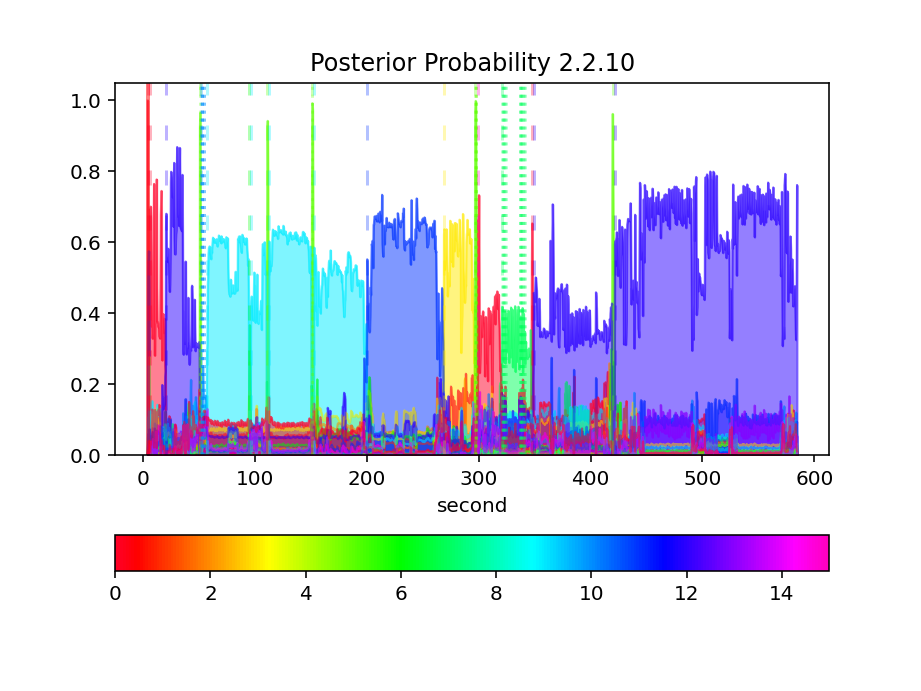
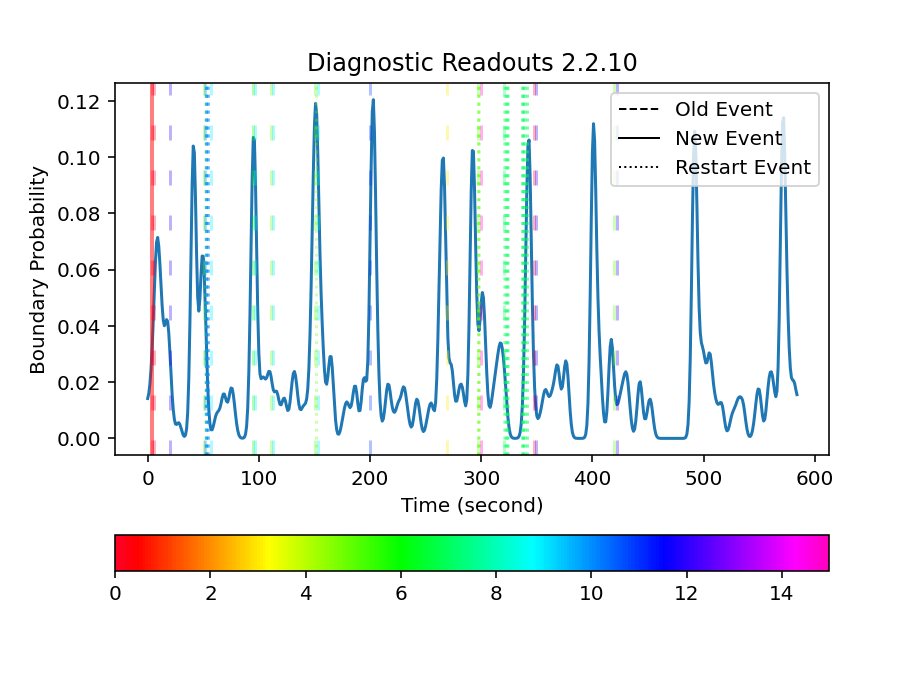
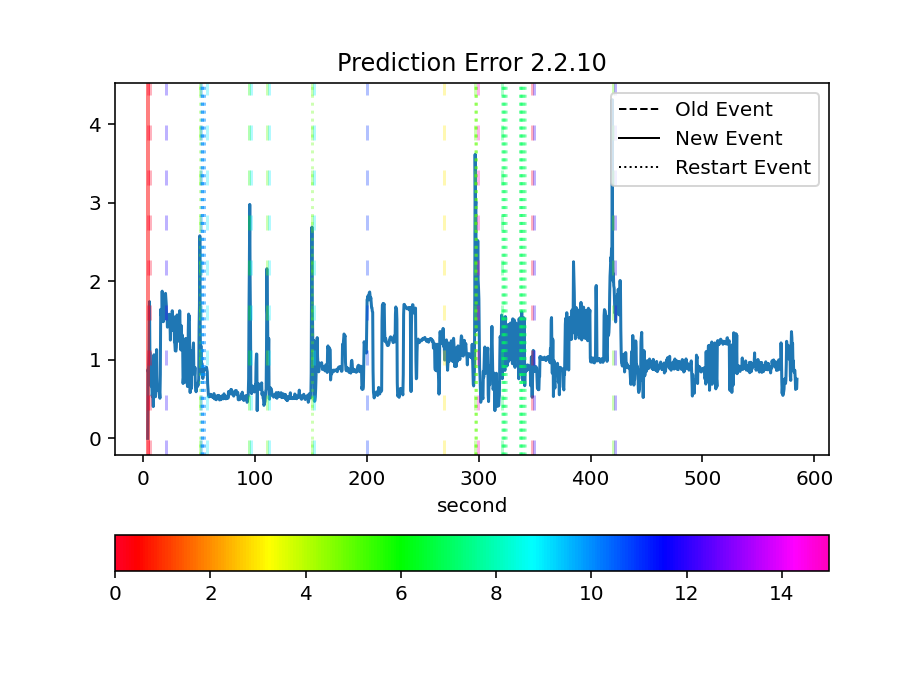
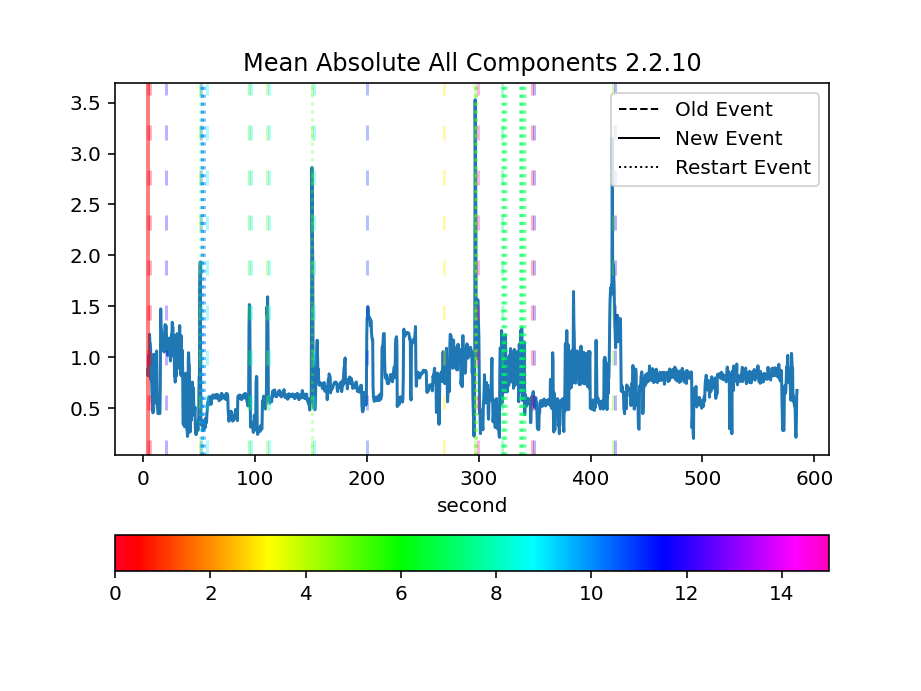
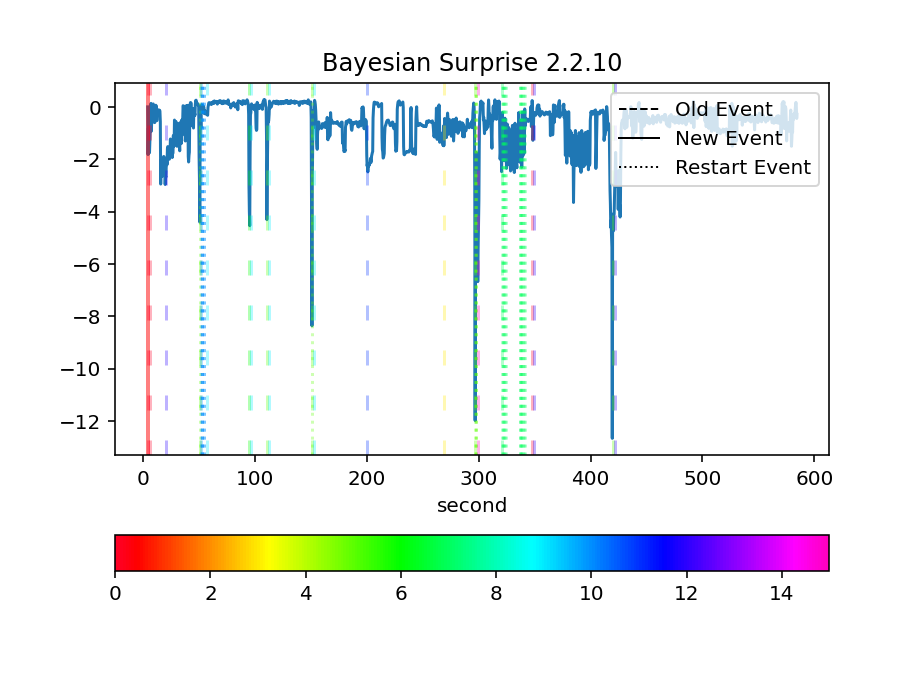
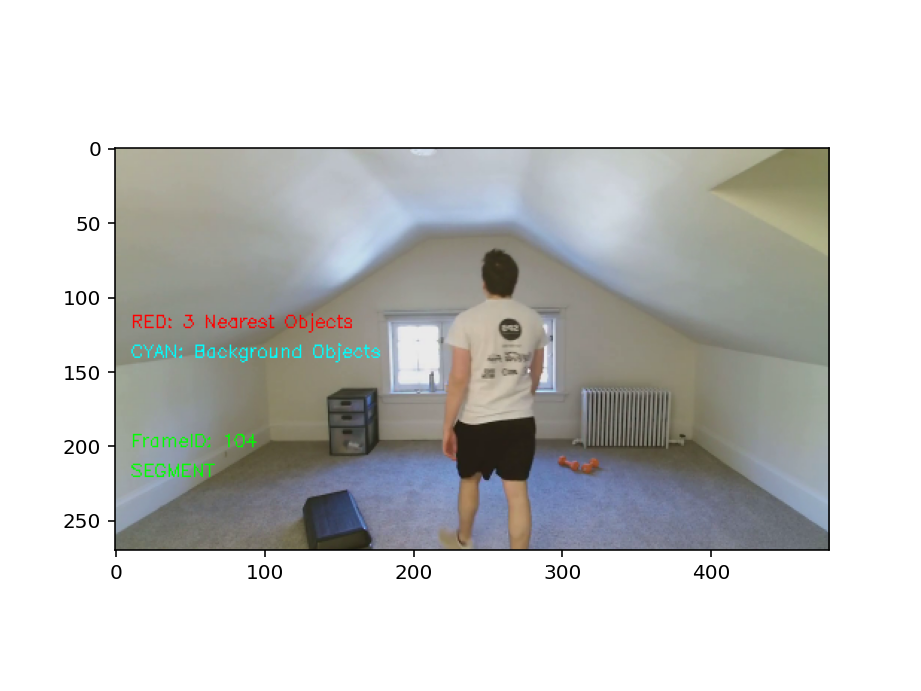

In [83]:
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(run_select, listen_to_run, epoch_select),
    pn.Row(pn.Column(frame_slider, second_slider, text_input), pn.Column(skel_checkbox, obj_checkbox, z_checkbox)),
    pn.Row(
        # pn.Column(flow_plot_post, objhand_plot, skel_plot_post_euclid),
        pn.Column(draw_frame_resampled, plot_diagnostic_readouts),
        pn.Column(plot_pe, plot_input_magnitude),
        pn.Column(plot_posterior, plot_surprise)
        )
)

# Launch the dashboard
dashboard.servable()

In [12]:
# inputdf.x_train_inverted.std()

In [13]:
# get_nearest([np.array(inputdf.x_train_inverted.loc[frame_slider.value, pred_objhand.columns].values, dtype=np.float32)],
#                                                 glove=True)

In [14]:
# get_nearest([np.array(inputdf.objhand_post.loc[frame_slider.value, pred_objhand.columns].values, dtype=np.float32)],
#                                                 glove=True)

In [15]:
# inputdf.objhand_post.loc[frame_slider.value, pred_objhand.columns].values

In [16]:
# dashboard = pn.Column(
#     pn.Row(title),
#     pn.Row(run_select, listen_to_run),
#     pn.Row(pn.Column(frame_slider, second_slider,text_input), pn.Column(skel_checkbox,obj_checkbox,z_checkbox)),
#     pn.Row(pn.Column(plot_posterior),
#           pn.Column(plot_diagnostic_readouts))
# )
#
# # Launch the dashboard
# dashboard.servable()

In [17]:
# %matplotlib inline
# fig, ax = plt.subplots()
# df = pd.DataFrame(sem_readouts['post'], index=inputdf.skel_post.index)
# #     df =df.loc[:, (df != 0).any(axis=0)]
# df =df.loc[:, (df > 1e-2).any(axis=0)]
# df.index = df.index / fps
# df.index.names = ['second']
# #     NUM_COLORS = len(df.columns)
# NUM_COLORS = sem_readouts['e_hat'].max()
# cm = plt.get_cmap('gist_rainbow')
# ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
# df_nms = df[df.eq(df.where(df != 0).max(1), axis=0)].fillna(0)
# # df.plot.area(ax=ax, stacked=False)
# df_nms.plot.area(ax=ax, stacked=False, linewidth=0.1)

In [18]:
# df.eq(df.where(df != 0).max(1), axis=0).astype(int)

In [19]:
#     df = pd.DataFrame(sem_readouts['post'], index=inputdf.skel_post.index)
# #     df =df.loc[:, (df != 0).any(axis=0)]
#     df =df.loc[:, (df > 1e-2).any(axis=0)]
#     df.index = df.index / fps
#     df.index.names = ['second']
#     NUM_COLORS = len(df.columns)
# #     NUM_COLORS = sem_readouts['e_hat'].max()
#     NUM_COLORS
#     sem_readouts['e_hat']
#     sem_readouts['post'].argmax(axis=1).max()

In [20]:
# np.sum(np.abs(np.argmax(sem_readouts['post'], axis=1) - sem_readouts['e_hat']))

In [21]:
# diff = sem_readouts['boundaries'][1:].astype(bool).astype(int) - (sem_readouts['e_hat'][1:] - sem_readouts['e_hat'][:-1]).astype(bool).astype(int)

In [22]:
# sem_readouts['boundaries'][1:][diff != 0]

In [23]:
# False ^ True

In [24]:
# (sem_readouts['e_hat'][1:] - sem_readouts['e_hat'][:-1]).astype(bool).sum()

In [25]:
# sem_readouts['boundaries'].astype(bool).sum()

In [26]:
# objdf_z.loc[114, :].dropna(), inputdf.categories_z.loc[114, :].dropna()

In [27]:
# categories_z = inputdf.categories_z
# odf_z = objdf_z[objdf_z.index == 114]
# odf_z = odf_z[odf_z.columns[~odf_z.isna().any()].tolist()]
# odf_z
# cat_z = categories_z[categories_z.index == 114]
# cat_z = cat_z[cat_z.columns[~cat_z.isna().any()].tolist()]
# cat_z 
# instances_z = set([x.split('_')[0] for x in odf_z.columns])
# instances_z

In [28]:
# list(pd.Series(odf_z.filter(regex='dist_z$').iloc[0, :]).sort_values().index)

In [29]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Start with one
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot([1,2,3])

# # Now later you get a new subplot; change the geometry of the existing
# n = len(fig.axes)
# for i in range(n):
#     fig.axes[i].change_geometry(n+1, 1, i+1)

# # Add the new
# ax = fig.add_subplot(n+1, 1, n+1)
# ax.plot([4,5,6])

# plt.show() 

In [30]:
# categories_z = inputdf.categories_z
# odf_z = objdf_z[objdf_z.index == 114]
# odf_z = odf_z[odf_z.columns[~odf_z.isna().any()].tolist()]
# odf_z
# cat_z = categories_z[categories_z.index == 114]
# cat_z = cat_z[cat_z.columns[~cat_z.isna().any()].tolist()]
# cat_z 
# instances_z = set([x.split('_')[0] for x in odf_z.columns])
# instances_z

In [31]:
# list(pd.Series(odf_z.filter(regex='dist_z$').iloc[0, :]).sort_values().index)

In [32]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Start with one
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot([1,2,3])

# # Now later you get a new subplot; change the geometry of the existing
# n = len(fig.axes)
# for i in range(n):
#     fig.axes[i].change_geometry(n+1, 1, i+1)

# # Add the new
# ax = fig.add_subplot(n+1, 1, n+1)
# ax.plot([4,5,6])

# plt.show() 

In [33]:
# categories_z = inputdf.categories_z
# odf_z = objdf_z[objdf_z.index == 114]
# odf_z = odf_z[odf_z.columns[~odf_z.isna().any()].tolist()]
# odf_z
# cat_z = categories_z[categories_z.index == 114]
# cat_z = cat_z[cat_z.columns[~cat_z.isna().any()].tolist()]
# cat_z 
# instances_z = set([x.split('_')[0] for x in odf_z.columns])
# instances_z

In [34]:
# list(pd.Series(odf_z.filter(regex='dist_z$').iloc[0, :]).sort_values().index)

In [35]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Start with one
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot([1,2,3])

# # Now later you get a new subplot; change the geometry of the existing
# n = len(fig.axes)
# for i in range(n):
#     fig.axes[i].change_geometry(n+1, 1, i+1)

# # Add the new
# ax = fig.add_subplot(n+1, 1, n+1)
# ax.plot([4,5,6])

# plt.show() 

In [36]:
# categories_z = inputdf.categories_z
# odf_z = objdf_z[objdf_z.index == 114]
# odf_z = odf_z[odf_z.columns[~odf_z.isna().any()].tolist()]
# odf_z
# cat_z = categories_z[categories_z.index == 114]
# cat_z = cat_z[cat_z.columns[~cat_z.isna().any()].tolist()]
# cat_z 
# instances_z = set([x.split('_')[0] for x in odf_z.columns])
# instances_z

In [37]:
# list(pd.Series(odf_z.filter(regex='dist_z$').iloc[0, :]).sort_values().index)

In [38]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Start with one
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot([1,2,3])

# # Now later you get a new subplot; change the geometry of the existing
# n = len(fig.axes)
# for i in range(n):
#     fig.axes[i].change_geometry(n+1, 1, i+1)

# # Add the new
# ax = fig.add_subplot(n+1, 1, n+1)
# ax.plot([4,5,6])

# plt.show() 

In [39]:
# video_button = pn.widgets.Button(name='Draw the video', button_type='primary')
# from tqdm.notebook import tqdm
# def draw_video(video_button):
#     output_video_path = f'output/videos/{run_select.value}_{tag}__{epoch}.avi'
#     if not os.path.exists(f'output/videos'):
#         os.makedirs('output/videos')
#     if os.path.exists(output_video_path):
#         print('Video already drawn!!!')
#         return
    
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     cv2_writer = cv2.VideoWriter(output_video_path, fourcc=fourcc, fps=15,
#                                       frameSize=(640, 960), isColor=True)
#     for frame_id, frame in tqdm(anchored_frames.items()):
#         img = draw_frame_resampled(frame_id, skel_checkbox=True, obj_checkbox=True, run_select=run_select.value, get_img=True)
#         img = cv2.resize(img, dsize=(640, 480))
#         diagnostic = plot_diagnostic_readouts(frame_id, run_select.value, title='', get_img=True)
#         diagnostic = cv2.resize(diagnostic, dsize=(640, 480))
#         concat = np.concatenate([img, diagnostic], axis=0)
#         cv2_writer.write(concat)
#     cv2_writer.release()
#     print(f'Done {output_video_path}')
    

# video_button.on_click(draw_video)
# video_button

## Play with biserial and pearson_r

In [40]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy.stats as stats

# # gt_freqs = pkl.load(open('output/run_sem/{tag}/2.2.3_kinect_trimfeb_27_like_21_replicate_gtfreqs.pkl', 'rb'))
# # sem_readouts = pkl.load(open('output/run_sem/{tag}/2.2.3_kinect_trimfeb_27_like_21_replicate_diagnostic_0.pkl', 'rb'))

In [41]:
# def get_point_biserial(boundaries_binned, binned_comp) -> float:
#     M_1 = np.mean(binned_comp[boundaries_binned != 0])
#     M_0 = np.mean(binned_comp[boundaries_binned == 0])

#     n_1 = np.sum(boundaries_binned != 0)
#     n_0 = np.sum(boundaries_binned == 0)
#     n = n_1 + n_0

#     s = np.std(binned_comp)
#     r_pb = (M_1 - M_0) / s * np.sqrt(n_1 * n_0 / (float(n) ** 2))
#     return r_pb
# pred_boundaries = get_binned_prediction(sem_readouts['post'], second_interval=second_interval,
#                                         sample_per_second=3)
# # Padding prediction boundaries, could be changed to have higher resolution but not necessary
# pred_boundaries = np.hstack([[0] * round(first_frame / fps / second_interval), pred_boundaries]).astype(bool)
# # gt_freqs_local = gaussian_filter1d(gt_freqs, 2)
# last = min(len(pred_boundaries), len(gt_freqs))
# bicorr = get_point_biserial(pred_boundaries[:last].astype(int), gt_freqs[:last])
# bicorr

In [42]:
# r, p = stats.pearsonr(pred_boundaries[:last].astype(int), gt_freqs[:last])
# r, p

In [43]:
# pred_boundaries_gaussed = gaussian_filter1d(pred_boundaries.astype(float), 1)
# r, p = stats.pearsonr(pred_boundaries_gaussed[:last], gt_freqs[:last])
# r, p

In [44]:
# fig, axs = plt.subplots(2, 2, figsize=(10,10))

In [45]:
# pred_boundaries_tinker = pred_boundaries.copy()
# pred_boundaries_tinker[:200] = 0
# pred_boundaries_tinker[200:] = 0
# print(np.where(pred_boundaries_tinker != 0))
# pred_boundaries_tinker[[182]] = 1
# r, p = stats.pearsonr(pred_boundaries_tinker[:last], gt_freqs[:last])
# r, p

In [46]:
# pred_boundaries_tinker_gaussed = gaussian_filter1d(pred_boundaries_tinker.astype(float), 1)
# r_blurred, p = stats.pearsonr(pred_boundaries_tinker_gaussed[:last], gt_freqs[:last])
# r_blurred, p

In [47]:
# axs[0][0].plot(gt_freqs, label='Subjects')
# # axs[0][0].plot(pred_boundaries_tinker, label='Model')
# axs[0][0].vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# axs[0][0].plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# axs[0][0].text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# axs[0][0].set_ylim()
# axs[0][0].legend()
# # fig

In [48]:
# plt.plot(gt_freqs, label='Subjects')
# # plt.plot(pred_boundaries_tinker, label='Model')
# plt.vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# plt.plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# plt.text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# plt.ylim()
# plt.legend()

In [49]:
# pred_boundaries_tinker = pred_boundaries.copy()
# pred_boundaries_tinker[:150] = 0
# pred_boundaries_tinker[200:] = 0
# print(np.where(pred_boundaries_tinker != 0))
# # pred_boundaries_tinker[[165, 179]] = 1
# r, p = stats.pearsonr(pred_boundaries_tinker[:last], gt_freqs[:last])
# r, p

In [50]:
# pred_boundaries_tinker_gaussed = gaussian_filter1d(pred_boundaries_tinker.astype(float), 1)
# r_blurred, p = stats.pearsonr(pred_boundaries_tinker_gaussed[:last], gt_freqs[:last])
# r_blurred, p

In [51]:
# plt.plot(gt_freqs, label='Subjects')
# # plt.plot(pred_boundaries_tinker, label='Model')
# plt.vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# plt.plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# plt.text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# plt.ylim()
# plt.legend()

In [52]:
# axs[0][1].plot(gt_freqs, label='Subjects')
# # ax[0][1].plot(pred_boundaries_tinker, label='Model')
# axs[0][1].vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# axs[0][1].plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# axs[0][1].text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# axs[0][1].set_ylim()
# axs[0][1].legend()

In [53]:
# pred_boundaries_tinker = pred_boundaries.copy()
# pred_boundaries_tinker[:90] = 0
# pred_boundaries_tinker[98:] = 0
# print(np.where(pred_boundaries_tinker != 0))
# pred_boundaries_tinker[87:94] = 1
# r, p = stats.pearsonr(pred_boundaries_tinker[:last], gt_freqs[:last])
# r, p

In [54]:
# pred_boundaries_tinker_gaussed = gaussian_filter1d(pred_boundaries_tinker.astype(float), 1)
# r_blurred, p = stats.pearsonr(pred_boundaries_tinker_gaussed[:last], gt_freqs[:last])
# r_blurred, p

In [55]:
# axs[1][1].plot(gt_freqs, label='Subjects')
# # axs[1][1].plot(pred_boundaries_tinker, label='Model')
# axs[1][1].vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# axs[1][1].plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# axs[1][1].text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# axs[1][1].set_ylim()
# axs[1][1].legend()

In [56]:
# pred_boundaries_tinker = pred_boundaries.copy()
# pred_boundaries_tinker[:100] = 0
# pred_boundaries_tinker[100:] = 0
# print(np.where(pred_boundaries_tinker != 0))
# pred_boundaries_tinker[90] = 1
# r, p = stats.pearsonr(pred_boundaries_tinker[:last], gt_freqs[:last])
# r, p

In [57]:
# pred_boundaries_tinker_gaussed = gaussian_filter1d(pred_boundaries_tinker.astype(float), 1)
# r_blurred, p = stats.pearsonr(pred_boundaries_tinker_gaussed[:last], gt_freqs[:last])
# r_blurred, p

In [58]:
# axs[1][0].plot(gt_freqs, label='Subjects')
# # axs[1][1].plot(pred_boundaries_tinker, label='Model')
# axs[1][0].vlines(np.where(pred_boundaries_tinker != 0)[0], ymin=0, ymax=1, alpha=0.5, label='Model', linestyles='dotted')
# axs[1][0].plot(pred_boundaries_tinker_gaussed, label='Gauss', alpha=0.3)
# axs[1][0].text(0.1, 0.8, f'bicorr={r:.3f}, pearson_r={r_blurred:.3f}')
# axs[1][0].set_ylim()
# axs[1][0].legend()
# fig

## Tinker with numbers

In [59]:

# import numpy as np
# import pickle as pkl
# from utils import get_point_biserial
# import matplotlib
# import matplotlib.pyplot as plt
# import scipy.stats as stats
# from scipy.ndimage import gaussian_filter1d
# %matplotlib inline

# gt_freqs = pkl.load(open('output/run_sem/{tag}/1.1.8_kinect_trimfeb_17_vw300_lmda1e10_df100_gtfreqs.pkl', 'rb'))

# sorted_indices = np.argsort(gt_freqs)

# bicorrs = []
# pearsons = []
# pearsons_random = []
# for i in range(1, sorted_indices.shape[0]):
#     dummy = np.zeros(shape=(745,))
#     dummy[sorted_indices[-i:]] = 1
#     dummy_gaussian = gaussian_filter1d(dummy.astype(float), 1)
#     bicorrs.append(get_point_biserial(dummy, gt_freqs))
#     r_blurred, p = stats.pearsonr(dummy_gaussian, gt_freqs)
#     pearsons.append(r_blurred)
    
#     dummy = np.zeros(shape=(745,))
#     dummy[np.random.choice(745, i)] = 1
#     dummy[sorted_indices[-i:]] = 1
#     dummy_gaussian = gaussian_filter1d(dummy.astype(float), 1)
#     r_blurred_random, p = stats.pearsonr(dummy_gaussian, gt_freqs)
#     pearsons_random.append(r_blurred_random)
# plt.plot(pearsons_random, label='Ideal + Random')
# plt.plot(pearsons, label='Ideal')
# plt.xlabel('# Boundaries')
# plt.ylabel('Pearson Correlation')
# plt.title('Ideal Pearson Correlation for each #Boundary - 1.1.8')
# plt.legend()
# plt.savefig('Pearson_boundary.png')
# plt.show()
# plt.close()

In [60]:
# pred_objhand.index.get_indexer([1402])

## Dashboard Testing before Integration

In [61]:
# dashboard = pn.Column(
#     pn.Row(title),
#     pn.Row(run_select, listen_to_run),
#     pn.Row(pn.Column(frame_slider, second_slider,text_input), pn.Column(skel_checkbox,obj_checkbox,z_checkbox)),
#            pn.Column(draw_frame_resampled)
# )

# # Launch the dashboard
# dashboard.servable()